In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import scipy.stats as stats

In [2]:
fluence = pd.read_csv('reinserted_thermal_fluence.csv')

In [3]:
fluence

,# timestamp,cesium_val_0,cesium_val_1,cesium_val_2,cesium_val_3,cesium_val_4,cesium_val_5,cesium_val_6,cesium_val_7,cesium_val_8,...,fluence_val_803,fluence_val_804,fluence_val_805,fluence_val_806,fluence_val_807,fluence_val_808,fluence_val_809,fluence_val_810,fluence_val_811,fluence_val_812
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,3.474796e-08,1.707146e-07,7.250270e-07,1.518698e-07,2.655534e-07,1.096870e-07,4.931048e-07,5.913665e-08,7.028061e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,2.246938e-06,2.872698e-06,2.737213e-06,3.099643e-06,2.319968e-06,2.971253e-06,4.813968e-07,1.661822e-06,3.443706e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,4.538420e-06,4.424400e-06,3.635429e-06,5.124641e-06,4.557323e-06,5.301739e-06,3.826000e-06,6.284903e-06,5.364588e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,191.0,0.000000e+00,5.054584e-05,5.790360e-05,4.756137e-05,0.000000e+00,0.000000e+00,6.990133e-05,0.000000e+00,4.825021e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,192.0,5.011145e-05,8.686642e-05,0.000000e+00,4.515687e-05,0.000000e+00,0.000000e+00,4.304290e-05,4.031293e-05,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193,193.0,0.000000e+00,0.000000e+00,4.521334e-05,7.796768e-05,0.000000e+00,4.886403e-05,0.000000e+00,0.000000e+00,6.935493e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,194.0,0.000000e+00,4.109691e-05,0.000000e+00,9.213985e-05,7.296321e-05,0.000000e+00,0.000000e+00,3.900867e-05,4.373237e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
def bin_names(arr):
    arr_names = []
    for i in range(len(arr)):
        arr[i] = np.format_float_scientific(arr[i], unique=False, precision=2)
        if i+2 > len(arr):
            break
        else:
            arr[i+1] = np.format_float_scientific(arr[i+1], unique=False, precision=2)
            arr_names.append(str([str(arr[i]) + ':' + str(arr[i+1])]))
    return arr_names

In [89]:
def fluence_bins(fluence, fluence_col_start):
    fluence_only = fluence.iloc[:,fluence_col_start:]
    timestamp = fluence[['# timestamp']]
    fluence_t = pd.concat([timestamp, fluence_only], axis=1)
    # Read data
    Tbl = fluence_t

    # Extract data
    Xvals = Tbl.iloc[:,1:-1].to_numpy()
    Yvals = Tbl.iloc[:,-1].to_numpy()
    timestamps = Tbl.iloc[:,0].to_numpy()
    nRows, nCols = Xvals.shape
    #Xavg = np.mean(Xvals, axis=1)

    # define bins
    binMax = Tbl.max().max()
    binInt = binMax/200
    hEdges = np.arange(0, binMax+binInt, binInt)
    nBins = len(hEdges)-1

    # fill histogram matrix
    nCountsX = np.zeros((nRows, nBins), dtype=np.uint16)
    for n in range(nRows):
        nCountsX[n,:], _ = np.histogram(Xvals[n,:], hEdges)
        
    counts_df = pd.DataFrame(nCountsX)
    hEdges_name = bin_names(hEdges)
    counts_df.index = timestamps
    counts_df.index.name = 't'
    counts_df.columns = hEdges_name
    return counts_df

In [94]:
def cesium_bins(fluence, fluence_col_start):
    cesium_only = fluence.iloc[:,100:750]
    timestamp = fluence[['# timestamp']]
    cesium_t = pd.concat([timestamp, cesium_only], axis=1)
    display(cesium_t)
    # Read data
    Tbl = cesium_t

    # Extract data
    Xvals = Tbl.iloc[:,1:-1].to_numpy()
    Yvals = Tbl.iloc[:,-1].to_numpy()
    timestamps = Tbl.iloc[:,0].to_numpy()
    nRows, nCols = Xvals.shape
    #Xavg = np.mean(Xvals, axis=1)

    # define bins
    binMax = Tbl.max().max()
    binInt = binMax/200
    hEdges = np.arange(0, binMax+binInt, binInt)
    nBins = len(hEdges)-1

    # fill histogram matrix
    nCountsX = np.zeros((nRows, nBins), dtype=np.uint16)
    for n in range(nRows):
        nCountsX[n,:], _ = np.histogram(Xvals[n,:], hEdges)
    
    counts_df = pd.DataFrame(nCountsX)
    hEdges_name = bin_names(hEdges)
    counts_df.index = timestamps
    counts_df.index.name = 't'
    counts_df.columns = hEdges_name
    return counts_df

In [95]:
fluence_binned = fluence_bins(fluence, 814)
cesium_binned = cesium_bins(fluence, 814)

,# timestamp,cesium_val_99,cesium_val_100,cesium_val_101,cesium_val_102,cesium_val_103,cesium_val_104,cesium_val_105,cesium_val_106,cesium_val_107,...,cesium_val_739,cesium_val_740,cesium_val_741,cesium_val_742,cesium_val_743,cesium_val_744,cesium_val_745,cesium_val_746,cesium_val_747,cesium_val_748
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN
2,2.0,8.200455e-07,3.338701e-08,4.526054e-07,2.997362e-07,1.249157e-07,7.955748e-08,2.176824e-07,3.547469e-07,2.038963e-07,...,5.779885e-07,2.074657e-07,1.447878e-08,4.360337e-08,8.010793e-07,1.291519e-07,1.169024e-08,1.083793e-08,7.641622e-07,5.059543e-07
3,3.0,2.577929e-06,9.210601e-07,2.401721e-06,3.362634e-06,2.234000e-06,2.817969e-06,1.300781e-06,9.209652e-07,1.168604e-06,...,2.157405e-06,3.540385e-06,1.936438e-06,1.722725e-06,2.576479e-06,3.273579e-06,1.554766e-06,2.699897e-06,2.859326e-06,1.262517e-06
4,4.0,4.772079e-06,5.676323e-06,5.530703e-06,4.639659e-06,5.201164e-06,4.189884e-06,6.128542e-06,6.247439e-06,0.000000e+00,...,2.972177e-06,0.000000e+00,5.917066e-06,5.253579e-06,0.000000e+00,4.502366e-06,0.000000e+00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,191.0,0.000000e+00,5.713876e-05,0.000000e+00,0.000000e+00,3.960574e-05,1.038381e-04,7.551729e-05,5.446175e-05,9.529142e-05,...,0.000000e+00,8.818807e-05,4.398897e-05,0.000000e+00,4.282726e-05,0.000000e+00,4.417476e-05,5.059371e-05,7.580261e-05,8.460132e-05
192,192.0,3.789584e-05,4.479913e-05,0.000000e+00,0.000000e+00,8.590931e-05,4.857387e-05,9.044694e-05,4.118826e-05,8.249833e-05,...,0.000000e+00,9.721944e-05,7.844089e-05,0.000000e+00,5.586431e-05,0.000000e+00,3.909070e-05,0.000000e+00,0.000000e+00,0.000000e+00
193,193.0,7.755700e-05,1.057653e-04,8.598999e-05,4.748313e-05,8.534226e-05,0.000000e+00,7.210005e-05,4.673653e-05,8.120404e-05,...,4.025328e-05,0.000000e+00,4.813837e-05,1.020347e-04,8.994625e-05,9.168256e-05,0.000000e+00,1.017187e-04,9.583920e-05,1.049762e-04
194,194.0,4.242633e-05,4.693858e-05,4.601229e-05,0.000000e+00,9.969860e-05,4.656879e-05,3.822992e-05,0.000000e+00,0.000000e+00,...,8.986251e-05,8.250158e-05,4.599324e-05,7.984602e-05,4.552563e-05,0.000000e+00,4.589899e-05,8.631785e-05,4.485685e-05,5.120847e-05


In [96]:
fluence_binned

,['0.0:7.21e+18'],['7.21e+18:1.44e+19'],['1.44e+19:2.16e+19'],['2.16e+19:2.88e+19'],['2.88e+19:3.6e+19'],['3.6e+19:4.32e+19'],['4.32e+19:5.04e+19'],['5.04e+19:5.77e+19'],['5.77e+19:6.49e+19'],['6.49e+19:7.21e+19'],...,['1.38e+21:1.38e+21'],['1.38e+21:1.39e+21'],['1.39e+21:1.4e+21'],['1.4e+21:1.41e+21'],['1.41e+21:1.41e+21'],['1.41e+21:1.42e+21'],['1.42e+21:1.43e+21'],['1.43e+21:1.43e+21'],['1.43e+21:1.44e+21'],['1.44e+21:1.45e+21']
t,,,,,,,,,,,,,,,,,,,,,
0.0,812,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0,812,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,778,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.0,102,161,130,198,200,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,104,0,0,1,67,127,114,178,156,60,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191.0,355,0,0,0,0,0,0,0,0,0,...,3,1,1,2,0,0,0,0,0,0
192.0,347,0,0,0,0,0,0,0,0,0,...,1,0,1,1,2,0,0,0,0,0
193.0,344,0,0,0,0,0,0,0,0,0,...,2,0,0,1,2,0,0,0,0,0


In [97]:
cesium_binned

,['0.0:0.975'],['0.975:1.95'],['1.95:2.92'],['2.92:3.9'],['3.9:4.88'],['4.88:5.85'],['5.85:6.83'],['6.83:7.8'],['7.8:8.78'],['8.78:9.75'],...,['185.0:186.0'],['186.0:187.0'],['187.0:188.0'],['188.0:189.0'],['189.0:190.0'],['190.0:191.0'],['191.0:192.0'],['192.0:193.0'],['193.0:194.0'],['194.0:195.0']
t,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0,648,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,649,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.0,649,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,647,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191.0,649,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192.0,649,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193.0,649,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(array([199.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.]),
 array([  0.        ,   8.28888889,  16.57777778,  24.86666667,
         33.15555556,  41.44444444,  49.73333333,  58.02222222,
         66.31111111,  74.6       ,  82.88888889,  91.17777778,
         99.46666667, 107.75555556, 116.04444444, 124.33333333,
        132.62222222, 140.91111111, 149.2       , 157.48888889,
        165.77777778, 174.06666667, 182.35555556, 190.64444444,
  

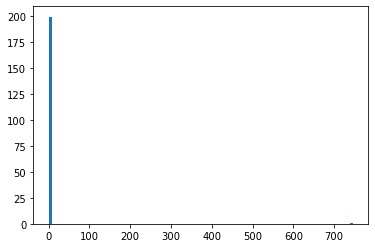

In [76]:
plt.hist(cesium_binned.iloc[4], bins = 90)

In [72]:
fluence_binned.to_csv('fluence.csv')
cesium_binned.to_csv('cesium.csv')

In [60]:
Tbl

,# timestamp,cesium_val_0,cesium_val_1,cesium_val_2,cesium_val_3,cesium_val_4,cesium_val_5,cesium_val_6,cesium_val_7,cesium_val_8,...,cesium_val_803,cesium_val_804,cesium_val_805,cesium_val_806,cesium_val_807,cesium_val_808,cesium_val_809,cesium_val_810,cesium_val_811,final_cesium_val
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,3.474796e-08,1.707146e-07,7.250270e-07,1.518698e-07,2.655534e-07,1.096870e-07,4.931048e-07,5.913665e-08,7.028061e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,2.246938e-06,2.872698e-06,2.737213e-06,3.099643e-06,2.319968e-06,2.971253e-06,4.813968e-07,1.661822e-06,3.443706e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,4.538420e-06,4.424400e-06,3.635429e-06,5.124641e-06,4.557323e-06,5.301739e-06,3.826000e-06,6.284903e-06,5.364588e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,191.0,0.000000e+00,5.054584e-05,5.790360e-05,4.756137e-05,0.000000e+00,0.000000e+00,6.990133e-05,0.000000e+00,4.825021e-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,192.0,5.011145e-05,8.686642e-05,0.000000e+00,4.515687e-05,0.000000e+00,0.000000e+00,4.304290e-05,4.031293e-05,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,193.0,0.000000e+00,0.000000e+00,4.521334e-05,7.796768e-05,0.000000e+00,4.886403e-05,0.000000e+00,0.000000e+00,6.935493e-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,194.0,0.000000e+00,4.109691e-05,0.000000e+00,9.213985e-05,7.296321e-05,0.000000e+00,0.000000e+00,3.900867e-05,4.373237e-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
Tbl.iloc[:,0].to_numpy()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [62]:
counts_df

,['0.0:0.975'],['0.975:1.95'],['1.95:2.92'],['2.92:3.9'],['3.9:4.88'],['4.88:5.85'],['5.85:6.83'],['6.83:7.8'],['7.8:8.78'],['8.78:9.75'],...,['185.0:186.0'],['186.0:187.0'],['187.0:188.0'],['188.0:189.0'],['189.0:190.0'],['190.0:191.0'],['191.0:192.0'],['192.0:193.0'],['193.0:194.0'],['194.0:195.0']
t,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0,747,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,771,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.0,778,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,746,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191.0,764,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192.0,760,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193.0,762,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
